In [1]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
def retrieve_data():
    engine =  create_engine('sqlite:///../data/database/happycows.db')
    with engine.connect() as con:
        milk = pd.read_sql_table('milk_volume', con)
        score = pd.read_sql_table('classification', con)
    return milk, score

In [3]:
def add_days_since_calving(milk, calvings):
    calving_dates = []
    for index, row in milk.iterrows():
        milk_date = row['date']
        animal_id = row['animal_id']
        c = calvings[(calvings['date_calved'] <= milk_date) & (calvings['animal_id'] == animal_id)]
        c = c['date_calved']
        if len(c) == 0:
            calving_dates.append(np.NaN)
        else:
            c = c.sort_values(ascending=False)
            calving_dates.append(c.iloc[0])
    
    milk['date_calved'] = calving_dates
    milk['days_since_calving'] = np.subtract(milk['date'], milk['date_calved'])
    return milk

In [4]:
milk, score = retrieve_data()

In [5]:
calvings = score[['animal_id', 'date_calved']].dropna(how='any').sort_values('date_calved')

In [6]:
s = add_days_since_calving(milk, calvings).dropna(how='any')
s['days_since_calving'] = s['days_since_calving'].apply(lambda x: x.days)
s.sample(10)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,date,animal_id,milk_weight,average_flow,max_flow,date_calved,days_since_calving
23250,2015-12-09,1930,20.3,2.850000,3.6,2014-02-27,650
51725,2016-06-19,2103,30.7,2.750000,4.1,2016-01-16,155
76445,2016-11-30,2056,36.9,4.050000,5.9,2015-08-14,474
21378,2015-11-25,1907,41.6,4.900000,7.1,2013-11-30,725
65647,2016-09-21,2156,26.8,4.000000,6.1,2016-08-13,39
55901,2016-07-18,2089,31.4,6.650000,9.8,2015-12-22,209
27489,2016-01-08,2091,43.1,1.466667,2.2,2016-01-03,5
17718,2015-10-31,1757,30.3,4.200000,5.6,2014-05-21,528
100920,2017-05-12,2052,37.5,4.800000,6.6,2016-10-16,208
8583,2015-08-29,1889,35.0,3.300000,4.4,2013-08-18,741


In [7]:
s = s.groupby('days_since_calving').mean().reset_index()
s = s[s['days_since_calving'] < 1000]

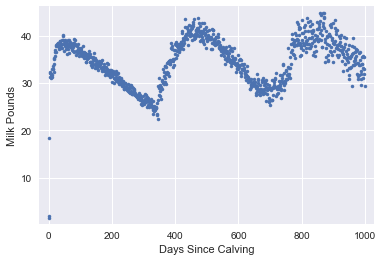

In [8]:
_ = plt.plot(s['days_since_calving'], s['milk_weight'], marker='.', linestyle='none')
_ = plt.margins(0.03)
_ = plt.xlabel('Days Since Calving')
_ = plt.ylabel('Milk Pounds')
plt.show()